# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 11.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=3f03c35c5e7ee80ef04633891528c0d771831ed5343f66115938c0c77af2a9ea
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=fa1af99133f9e8113a2bf36442abfe090c18e7605a727a79aff9d3b5e69764bc
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-d0meyfux
  Running command git clone --filter=blob:n

# About Dataset

### Dataset

Here the dataset which is being used in this project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

Full dataset can be found on

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

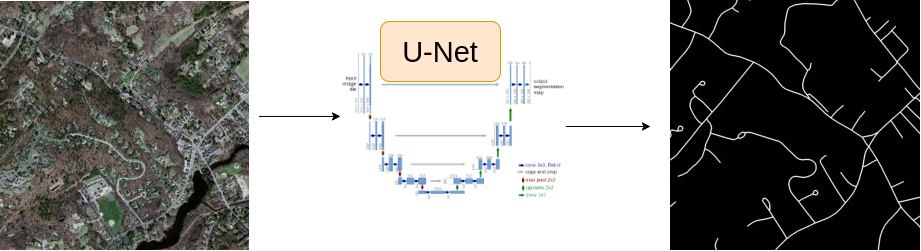

# Download Subset Dataset

In [71]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

fatal: destination path 'Road_seg_dataset' already exists and is not an empty directory.


# Some Common Imports

In [72]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [73]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [74]:
csv_file = '/content/Road_seg_dataset/train.csv'
data_dir = '/content/Road_seg_dataset/'

device = 'cuda'

epochs = 35
lr = 0.002 #learning rate
batch_size = 10
img_size = 512

encoder = 'timm-efficientnet-b0'
weights = 'imagenet'

In [75]:
df = pd.read_csv(csv_file)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [76]:
i = 15 #index
row = df.iloc[i]

image_path = data_dir + row.images
mask_path = data_dir + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

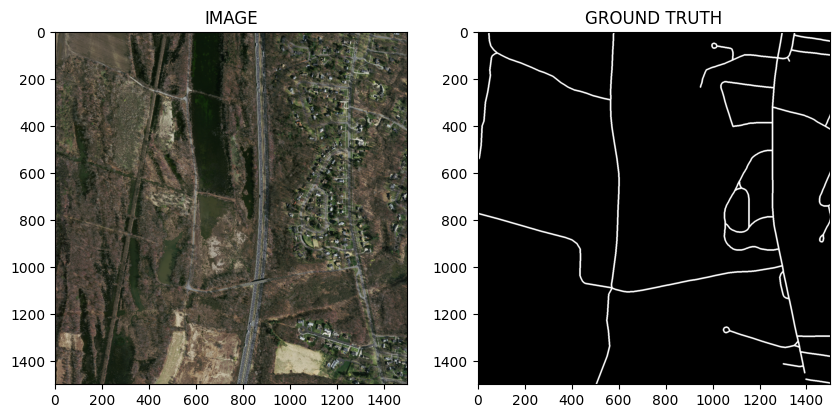

In [77]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [78]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [79]:
len(train_df)

159

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [80]:
import albumentations as A

In [81]:
def get_train_augs():
  return A.Compose([
      A.Resize(img_size, img_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(img_size, img_size)
  ])

# Task 4 : Create Custom Dataset

In [82]:
from torch.utils.data import Dataset

In [83]:
class segmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, i):
    row = self.df.iloc[i]

    image_path = data_dir + row.images
    mask_path = data_dir + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #(h, w, c)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w)
    mask = np.expand_dims(mask, axis= -1) #(h,w,c) here the channel c will be 1 as it is a grey scale image

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32) #(c , h , w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) #(c, h , w)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [84]:
trainset = segmentationDataset(train_df, get_train_augs())
valset = segmentationDataset(val_df, get_valid_augs())

In [85]:
print(f'There are {len(trainset)} images in the training set and {len(valset)} images in the validation set')

There are 159 images in the training set and 40 images in the validation set


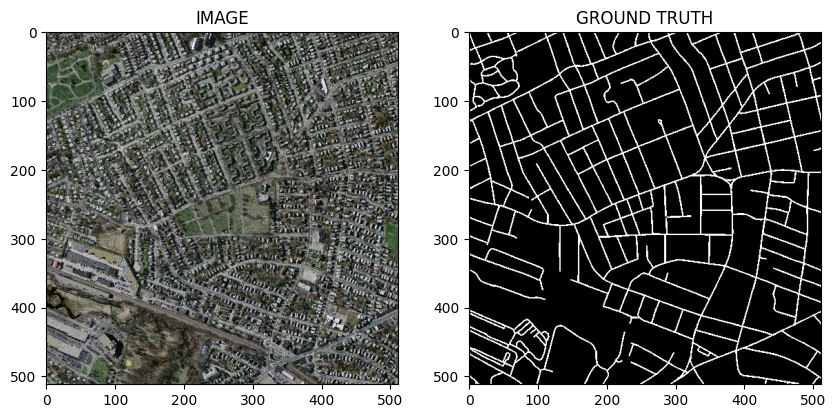

In [86]:
 i = 77

 image, mask = trainset[i]
 helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [87]:
from torch.utils.data import DataLoader

In [88]:
from random import shuffle
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(valset, batch_size= batch_size)

In [89]:
print(f'There are {len(trainloader)} batches in the training set and {len(validloader)} batches in the validation set')

There are 16 batches in the training set and 4 batches in the validation set


In [90]:
for images, mask in trainloader:
  print(f" One batch image Shape : {images.shape} ")
  print(f" One batch image Shape : {mask.shape} ")
  break;

 One batch image Shape : torch.Size([10, 3, 512, 512]) 
 One batch image Shape : torch.Size([10, 1, 512, 512]) 


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [91]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [92]:
class segmentationModel(nn.Module):

  def __init__(self):
    super(segmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = encoder,
        encoder_weights = weights,
        in_channels= 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits


In [93]:
model = segmentationModel()
model.to(device);

# Task 7 : Create Train and Validation Function

In [94]:
def train_fn(dataLoader, model, optimizer):

  model.train() # Turn ON dropout, Batchnorm, etc...

  total_loss = 0.0

  for images, masks in tqdm(dataLoader):

    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataLoader)

In [95]:
def eval_fn(dataLoader, model):

  model.eval() # Turn ON dropout, Batchnorm, etc...

  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(dataLoader):

      images = images.to(device)
      masks = masks.to(device)
      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss / len(dataLoader)

# Task 8 : Train Model

In [96]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [97]:
best_loss = np.inf

for j in range(epochs):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print("Saved Model")
    best_loss = valid_loss

  print(f"Epoch : {j+1} train_loss : {train_loss} valid_loss : {valid_loss}")



100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Saved Model
Epoch : 1 train_loss : 1.189766813069582 valid_loss : 1.104835331439972


100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


Saved Model
Epoch : 2 train_loss : 0.8638293370604515 valid_loss : 1.0058231353759766


100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Saved Model
Epoch : 3 train_loss : 0.7455772869288921 valid_loss : 0.8404098302125931


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Saved Model
Epoch : 4 train_loss : 0.6975576542317867 valid_loss : 0.7278559058904648


100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


Epoch : 5 train_loss : 0.6689804382622242 valid_loss : 0.7356225550174713


100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


Epoch : 6 train_loss : 0.6709474921226501 valid_loss : 0.7425879389047623


100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


Saved Model
Epoch : 7 train_loss : 0.6420949175953865 valid_loss : 0.7024732977151871


100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Saved Model
Epoch : 8 train_loss : 0.639137540012598 valid_loss : 0.6766021996736526


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch : 9 train_loss : 0.6210632808506489 valid_loss : 0.7291216254234314


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Saved Model
Epoch : 10 train_loss : 0.6115190088748932 valid_loss : 0.6560266762971878


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Epoch : 11 train_loss : 0.617939468473196 valid_loss : 0.7020975947380066


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Epoch : 12 train_loss : 0.6121583171188831 valid_loss : 0.6597940921783447


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch : 13 train_loss : 0.5930841974914074 valid_loss : 0.6851550787687302


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Saved Model
Epoch : 14 train_loss : 0.5894688665866852 valid_loss : 0.6387023776769638


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Saved Model
Epoch : 15 train_loss : 0.5906145423650742 valid_loss : 0.6294372826814651


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Epoch : 16 train_loss : 0.5912946537137032 valid_loss : 0.6334707289934158


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Epoch : 17 train_loss : 0.5740680079907179 valid_loss : 0.6566792726516724


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Epoch : 18 train_loss : 0.5913833379745483 valid_loss : 0.6628063768148422


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Saved Model
Epoch : 19 train_loss : 0.5770291611552238 valid_loss : 0.6171870976686478


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Epoch : 20 train_loss : 0.5687919575721025 valid_loss : 0.6308810412883759


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Epoch : 21 train_loss : 0.5619828142225742 valid_loss : 0.667929157614708


100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Epoch : 22 train_loss : 0.5662795566022396 valid_loss : 0.6604442298412323


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Epoch : 23 train_loss : 0.5601269621402025 valid_loss : 0.6223844140768051


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Saved Model
Epoch : 24 train_loss : 0.5626389253884554 valid_loss : 0.6151092499494553


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Saved Model
Epoch : 25 train_loss : 0.5559204965829849 valid_loss : 0.6113328337669373


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch : 26 train_loss : 0.5496469158679247 valid_loss : 0.6289500296115875


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch : 27 train_loss : 0.5463274288922548 valid_loss : 0.6414256244897842


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch : 28 train_loss : 0.5384804401546717 valid_loss : 0.6159599274396896


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch : 29 train_loss : 0.5399481989443302 valid_loss : 0.6152145713567734


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch : 30 train_loss : 0.572054909542203 valid_loss : 0.7324176579713821


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch : 31 train_loss : 0.5753846596926451 valid_loss : 0.6238152533769608


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Epoch : 32 train_loss : 0.5466012973338366 valid_loss : 0.6265920996665955


100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Epoch : 33 train_loss : 0.5539855472743511 valid_loss : 0.6151239573955536


100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


Epoch : 34 train_loss : 0.5384592264890671 valid_loss : 0.6143871396780014


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

Epoch : 35 train_loss : 0.531086603179574 valid_loss : 0.6318031847476959


# Task 9 : Inference

In [98]:
i = 30

model.load_state_dict(torch.load('/content/best-model.pt'))

image, mask = valset[i]
logits_mask = model(image.to(device).unsqueeze(0)) #(c , h, w) -> (b, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*10

<ipython-input-98-923fd9f66ed3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best-model.pt'))


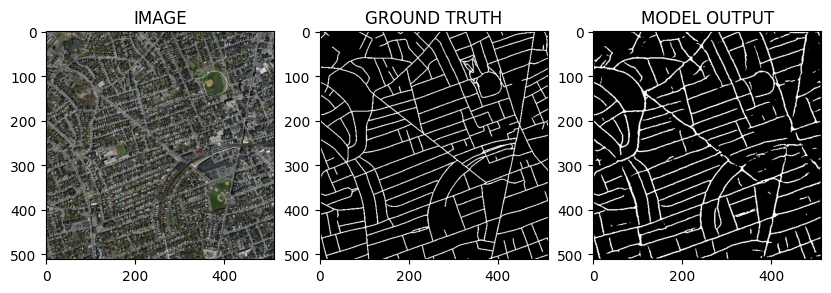

In [99]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))